In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model


In [2]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = DeepLabV3Plus(input_shape)
    model.summary()



94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

In [6]:
train_datagen = ImageDataGenerator(zoom_range=0.5,shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_dir = '/content/drive/MyDrive/dataset2/dataset2/train'
valid_dir='/content/drive/MyDrive/dataset2/dataset2/valid'
test_dir = '/content/drive/MyDrive/dataset2/dataset2/test'

In [8]:
train_generator = train_datagen.flow_from_directory(directory= "/content/drive/MyDrive/dataset2/dataset2/train", target_size=(256,256),batch_size=32)
valid_generator = val_datagen.flow_from_directory(directory= "/content/drive/MyDrive/dataset2/dataset2/valid", target_size=(256,256),batch_size=32)
test_generator = val_datagen.flow_from_directory(directory= "/content/drive/MyDrive/dataset2/dataset2/test", target_size=(256,256),batch_size=32)

Found 1798 images belonging to 2 classes.
Found 495 images belonging to 2 classes.
Found 441 images belonging to 2 classes.


In [9]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score
# Add new top layers for our classification task
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [10]:
# Create final model
model = Model(inputs=model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor='val_accuracy',
                              min_delta=0.01,
                              patience=5,
                               verbose =1,
                  restore_best_weights=True)

mc= ModelCheckpoint(filepath="best_model.h5",
                    monitor='val_accuracy',
                    min_delta = 0.01,
                    patience = 5,
                    verbose =1,
                    mode='max',
                    save_best_only = True)
cb = [es,mc]

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=6,
    validation_data=valid_generator,
    epochs=4,
    verbose =1,
    callbacks= cb,
    validation_steps=6
)

Epoch 1/4
6/6 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.5625  
Epoch 1: val_accuracy improved from -inf to 0.57292, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 1258s 208s/step - loss: 0.6688 - accuracy: 0.5625 - val_loss: 0.6566 - val_accuracy: 0.5729
Epoch 2/4
6/6 [==============================] - ETA: 0s - loss: 0.6254 - accuracy: 0.5417  
Epoch 2: val_accuracy improved from 0.57292 to 0.62500, saving model to best_model.h5
6/6 [==============================] - 1255s 215s/step - loss: 0.6254 - accuracy: 0.5417 - val_loss: 0.6759 - val_accuracy: 0.6250
Epoch 3/4
6/6 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.5052  
Epoch 3: val_accuracy improved from 0.62500 to 0.66146, saving model to best_model.h5
6/6 [==============================] - 1307s 221s/step - loss: 0.6186 - accuracy: 0.5052 - val_loss: 0.6610 - val_accuracy: 0.6615
Epoch 4/4
6/6 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.5469  
Epoch 4: val_accuracy did not improve from 0.66146
6/6 [==============================] - 1192s 201s/step - loss: 0.5963 - accuracy: 0.5469 - val_loss: 0.74

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

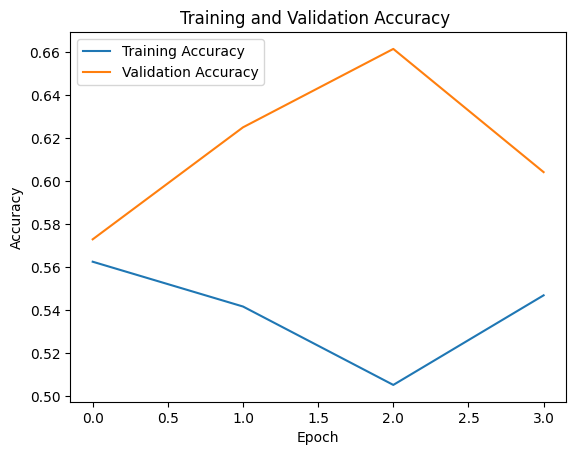

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

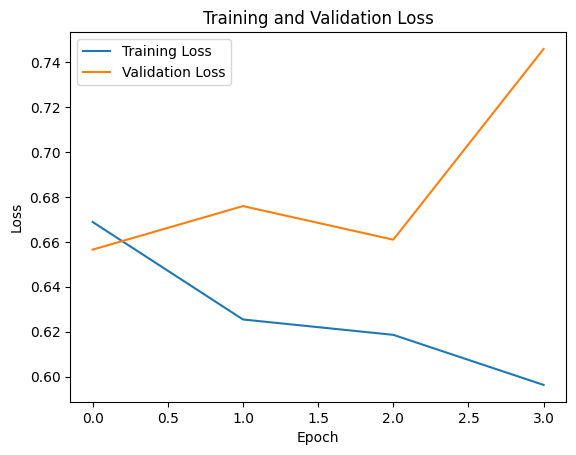

In [16]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Assuming you have trained the model using the code snippet provided
# You can access the final training and validation accuracy from the history object

# Get the final training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Print the final training and validation accuracy
print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)


Final Training Accuracy: 0.546875
Final Validation Accuracy: 0.6041666865348816


In [18]:
# Evaluate the model
batch_size = 32
test_steps = test_generator.samples // batch_size + 1
predictions = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

14/14 [==============================] - 271s 19s/step


In [19]:
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nWeighted F1 Score:", f1)


Weighted F1 Score: 0.6253589338259238


In [20]:
from sklearn.metrics import accuracy_score

# Compute testing accuracy
Testing_accuracy = accuracy_score(y_true, y_pred)

# Print Testing accuracy
print(" Testing Accuracy:", Testing_accuracy)


 Testing Accuracy: 0.7369614512471655
